In [6]:
import numpy as np
import pandas as pd 
import os

In [7]:
for dirname, _, filenames in os.walk('C:\\Users\\LENOVO\\OneDrive\\Desktop\\Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\LENOVO\OneDrive\Desktop\Dataset\crap.xls
C:\Users\LENOVO\OneDrive\Desktop\Dataset\ICBHI_final_database.rar
C:\Users\LENOVO\OneDrive\Desktop\Dataset\New Microsoft Excel Worksheet.xlsx
C:\Users\LENOVO\OneDrive\Desktop\Dataset\ICBHI_final_database\demographic_info_icbhi.txt
C:\Users\LENOVO\OneDrive\Desktop\Dataset\ICBHI_final_database\filename_differences.txt
C:\Users\LENOVO\OneDrive\Desktop\Dataset\ICBHI_final_database\filename_format.txt
C:\Users\LENOVO\OneDrive\Desktop\Dataset\ICBHI_final_database\New Microsoft Excel Worksheet.xlsx
C:\Users\LENOVO\OneDrive\Desktop\Dataset\ICBHI_final_database\patient_diagnosis (2) - Copy.csv
C:\Users\LENOVO\OneDrive\Desktop\Dataset\ICBHI_final_database\patient_diagnosis (2).csv
C:\Users\LENOVO\OneDrive\Desktop\Dataset\ICBHI_final_database\wheezes_crackles_diagnosis (1).csv
C:\Users\LENOVO\OneDrive\Desktop\Dataset\ICBHI_final_database\audio files\101_1b1_Al_sc_Meditron.wav
C:\Users\LENOVO\OneDrive\Desktop\Dataset\ICBHI_final_database\audio file

In [8]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import savefig



In [9]:
mypath = "C:\\Users\\LENOVO\\OneDrive\\Desktop\\Dataset\\ICBHI_final_database\\audio_and_txt_files"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file) 
print(p_id_in_file)


[101 101 102 104 104 104 104 104 104 105 106 106 107 107 107 107 107 107
 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107
 107 107 107 107 109 109 109 109 109 109 110 110 110 110 110 111 111 112
 112 112 112 112 113 113 113 113 113 113 114 114 114 114 114 116 116 117
 117 118 118 118 118 118 118 119 120 120 120 120 120 121 121 122 122 122
 122 122 122 122 122 122 123 124 124 124 124 124 124 125 126 127 128 129
 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130
 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130
 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130
 130 130 130 130 130 130 130 130 130 130 130 130 131 132 132 133 133 133
 133 133 133 133 133 133 133 133 133 133 133 133 133 133 133 133 134 134
 134 134 134 135 135 135 135 135 135 135 135 135 135 135 135 135 136 137
 137 138 138 138 138 138 138 138 138 138 138 138 138 138 138 138 138 138
 138 138 138 138 138 138 138 138 138 138 139 139 13

In [10]:
max_pad_len = 862 

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(f"Error details: {str(e)}")
        return None 
     
    return mfccs
mypath = "C:\\Users\\LENOVO\\OneDrive\\Desktop\\Dataset\\ICBHI_final_database\\audio_and_txt_files"
filepaths = [os.path.join(mypath, f) for f in filenames]

#filepaths = [join(mypath, f) for f in filenames]
p_diag1 = pd.read_csv("C:\\Users\\LENOVO\\OneDrive\\Desktop\\Dataset\\ICBHI_final_database\\patient_diagnosis (2).csv",header=None)
p_diag2 = pd.read_csv("C:\\Users\\LENOVO\\OneDrive\\Desktop\\Dataset\\ICBHI_final_database\\wheezes_crackles_diagnosis (1).csv",header=None)

disease_labels = np.array([p_diag1[p_diag1[0] == x][1].values[0] for x in p_id_in_file])
sound_labels = np.array([p_diag2[p_diag2[0] == x][1].values[0] for x in p_id_in_file])
features = [] 

for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

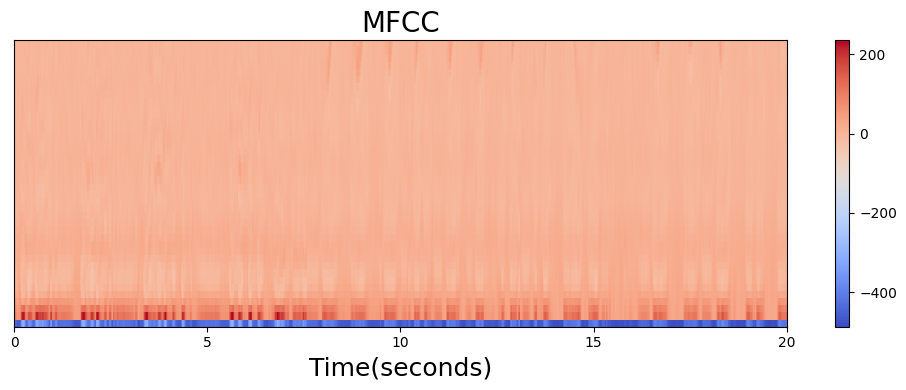

In [11]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[7], x_axis= 'time')
plt.xlabel('Time(seconds)', fontsize=18)
plt.rc('xtick', labelsize=13)
plt.colorbar()
plt.title('MFCC', fontsize=20)
plt.rc('ytick', labelsize=13)
plt.tight_layout()
plt.savefig('plot1.eps', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
features = np.array(features)
#features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 
#disease_labels1 = np.delete(disease_labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)
print(features)

[[[-2.83240112e+02 -3.47947754e+02 -5.26268555e+02 ... -5.21922974e+02
   -4.06852692e+02 -2.89752411e+02]
  [ 1.23838890e+02  1.25746849e+02  1.07862129e+02 ...  1.13700607e+02
    1.24025772e+02  1.09645515e+02]
  [ 1.19586182e+01  1.63965111e+01  7.01855469e+01 ...  7.70387115e+01
    4.00397797e+01  2.69621849e+01]
  ...
  [ 1.52501428e+00  1.33324397e+00  3.45390499e-01 ... -6.93255091e+00
   -1.13314509e+00  3.30386013e-01]
  [ 1.20639491e+00  2.39718056e+00  2.32282186e+00 ... -2.24808025e+00
   -9.54143405e-01  3.47525895e-01]
  [ 2.01286459e+00  2.08191490e+00  4.09331560e+00 ...  3.13392997e+00
   -6.14135683e-01  4.28399295e-01]]

 [[-3.76325562e+02 -4.39081726e+02 -5.70132507e+02 ... -4.97284393e+02
   -4.34393250e+02 -3.47046173e+02]
  [ 1.21729683e+02  1.23339386e+02  1.08900230e+02 ...  1.78229462e+02
    1.60716949e+02  1.16166016e+02]
  [ 1.12817755e+01  1.70431747e+01  6.13862686e+01 ...  6.72552185e+01
    5.17880058e+01  3.16052303e+01]
  ...
  [ 1.32843077e+00  4.9

In [13]:
unique_elements, counts_elements = np.unique(disease_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))
unique_elements1, counts_elements1 = np.unique(sound_labels, return_counts=True)
print(np.asarray((unique_elements1, counts_elements1)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]
[['Crackles' 'Healthy' 'Wheezes' 'Wheezes & Crackles']
 ['551' '50' '245' '71']]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


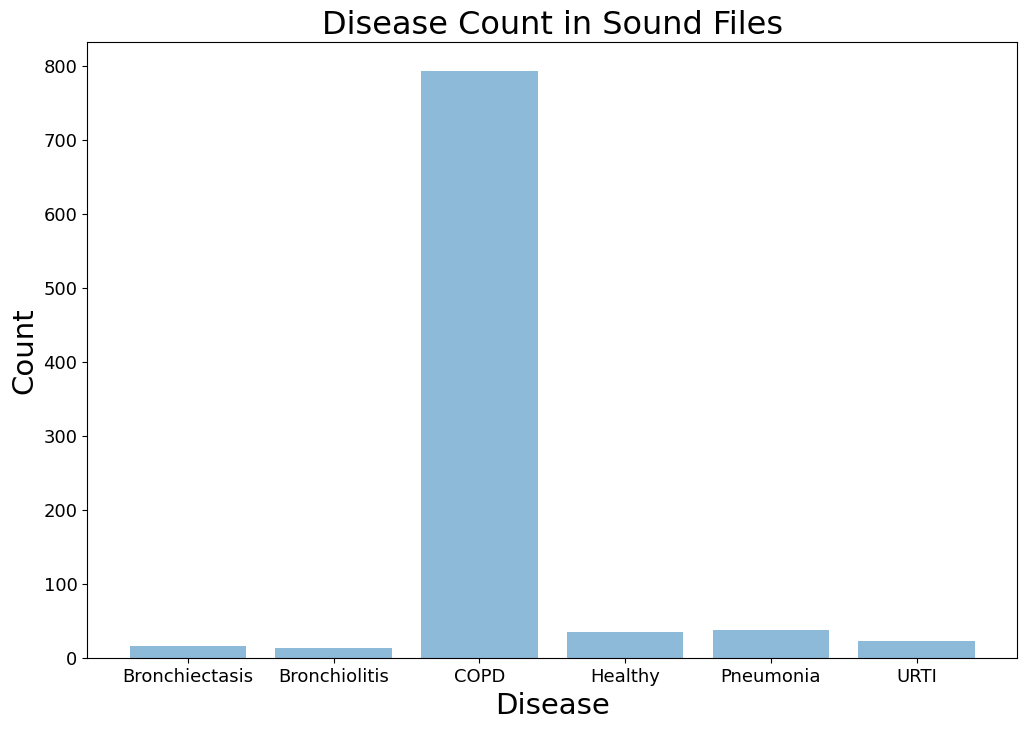

In [14]:
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count', fontsize=21)
plt.rc('ytick', labelsize=15)
plt.xlabel('Disease', fontsize=21)
plt.rc('xtick', labelsize=14.99)
plt.title('Disease Count in Sound Files', fontsize=23)
plt.savefig('plot2.eps', dpi=300, bbox_inches='tight')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


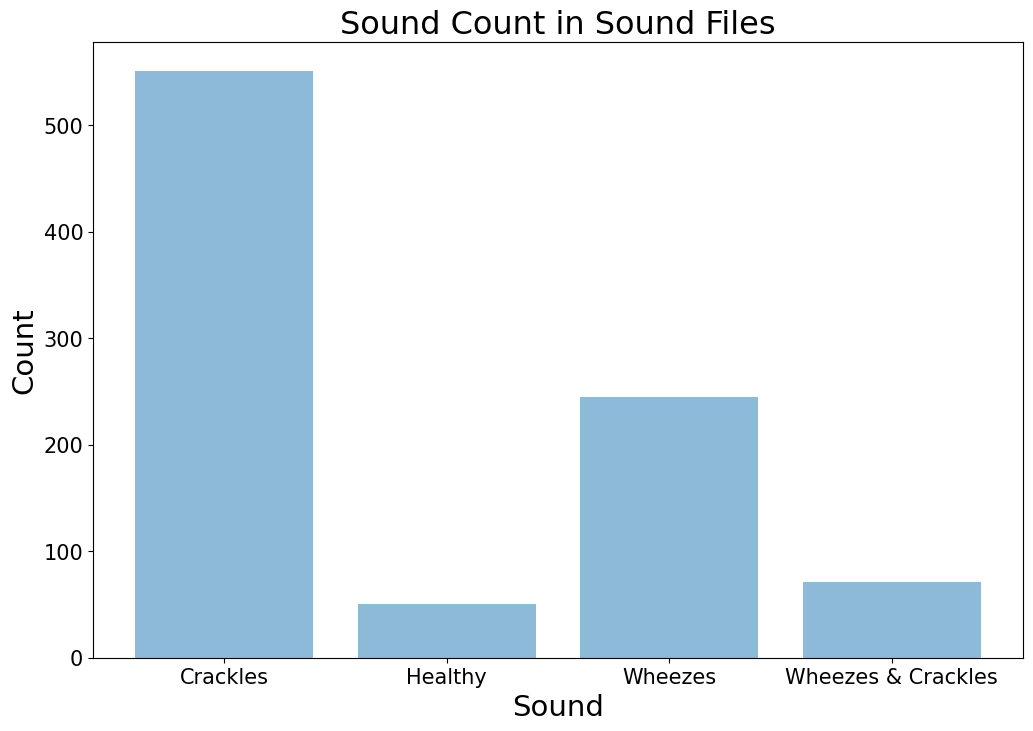

In [10]:
y_pos = np.arange(len(unique_elements1))
plt.figure(figsize=(12,8))
plt.bar(unique_elements1, counts_elements1, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements1)
plt.ylabel('Count', fontsize=21)
plt.rc('ytick', labelsize=15)
plt.xlabel('Sound', fontsize=21)
plt.rc('xtick', labelsize=14.99)
plt.title('Sound Count in Sound Files', fontsize=23)
plt.savefig('plot2.eps', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
le = LabelEncoder()
i_labels = le.fit_transform(disease_labels)
le1 = LabelEncoder()
i_labels1 = le1.fit_transform(sound_labels)
oh_labels = to_categorical(i_labels)
oh_labels1 = to_categorical(i_labels1)
features1 = np.reshape(features, (*features.shape,1)) 
features2 = np.reshape(features, (*features.shape,1)) 

In [16]:
x_train_disease, x_test_disease, y_train_disease, y_test_disease = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)
x_train_sound, x_test_sound, y_train_sound, y_test_sound = train_test_split(features2, oh_labels1, stratify=oh_labels1, 
                                                    test_size=0.2, random_state = 42)

num_rows = 40
num_columns = 862
num_channels = 1
    

#num_labels_disease = oh_labels.shape[1]
#num_labels_sound = oh_labels1.shape[1]
num_labels_disease = 6
num_labels_sound = 4

filter_size = 2

In [17]:
#x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    #test_size=0.2, random_state = 42)
from keras.layers import Input
num_rows = 40
num_columns = 862
num_channels = 1
'''
num_labels = oh_labels.shape[1]
num_labels1 = oh_labels1.shape[1]
filter_size = 2
'''
# Assuming num_classes_sound and num_classes_disease are the number of classes for sound and disease predictions
#num_classes_sound = oh_labels_sound.shape[4]
#num_classes_disease = oh_labels_disease.shape[8]

# Create input layer for common features
#input_shape_common = (num_frames, num_features_common)
#input_common = Input(shape=input_shape_common, name='input_common')

# Assuming you have sound and disease labels
num_labels_sound = 4
num_labels_disease = 6

# Input shape for sound data
input_shape_sound = (num_rows, num_columns, num_channels)  # Adjust based on your sound data shape

# Input shape for disease data
input_shape_disease = (num_rows, num_columns, num_channels)  # Adjust based on your disease data shape

# Filter size
filter_size = 2

# Create separate input layers for sound and disease data
input_sound = Input(shape=input_shape_sound, name='input_sound')
input_disease = Input(shape=input_shape_disease, name='input_disease')


In [23]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import numpy as np
from keras.layers import concatenate
from keras.models import Model
# Define the input shape based on your MFCC data
#input_shape = (40, 862)  # (max_pad_length, num_mfcc_coefficients)

# Define the input layer
#input_layer = Input(shape=input_shape)

# Add a 1D convolutional layer
x = Conv2D(filters=16, kernel_size=3, activation='relu')(input_sound)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.2)(x)

# Add more convolutional layers as needed
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.2)(x)

# Global average pooling layer
global_avg_pooling_sound = GlobalAveragePooling2D()(x)

# Add a 1D convolutional layer
x1 = Conv1D(filters=16, kernel_size=3, activation='relu')(input_disease)
x1 = MaxPooling2D(pool_size=2)(x1)
x1 = Dropout(0.2)(x1)

# Add more convolutional layers as needed
x1 = Conv1D(filters=32, kernel_size=3, activation='relu')(x1)
x1 = MaxPooling2D(pool_size=2)(x1)
x1 = Dropout(0.2)(x1)

# Global average pooling layer
global_avg_pooling_disease = GlobalAveragePooling2D()(x1)

merged = concatenate([global_avg_pooling_sound, global_avg_pooling_disease])

dense_merged = Dense(256, activation='relu')(merged)

# Output layers for sound and disease predictions
output_sound = Dense(num_labels_sound, activation='softmax', name='sound_output')(dense_merged)
output_disease = Dense(num_labels_disease, activation='softmax', name='disease_output')(dense_merged)

# Create the model
model = Model(inputs=[input_sound, input_disease], outputs=[output_sound, output_disease])

# Compile the model with appropriate loss functions for each output
model.compile(optimizer='adam', loss={'sound_output': 'categorical_crossentropy', 'disease_output': 'categorical_crossentropy'}, metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sound (InputLayer)    [(None, 40, 862, 1)]         0         []                            
                                                                                                  
 input_disease (InputLayer)  [(None, 40, 862, 1)]         0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 38, 860, 16)          160       ['input_sound[0][0]']         
                                                                                                  
 conv1d_7 (Conv1D)           (None, 40, 860, 16)          64        ['input_disease[0][0]']       
                                                                                              

In [25]:
history = model.fit(
    [x_train_sound, x_train_disease],  # Input features for sound and disease
    {'sound_output': y_train_sound, 'disease_output': y_train_disease},  # Output labels for sound and disease
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/10
19/19 [==============================] - 33s 2s/step - loss: 3.5109 - sound_output_loss: 2.2162 - disease_output_loss: 1.2947 - sound_output_accuracy: 0.4710 - disease_output_accuracy: 0.7747 - val_loss: 2.0927 - val_sound_output_loss: 1.3624 - val_disease_output_loss: 0.7303 - val_sound_output_accuracy: 0.6327 - val_disease_output_accuracy: 0.8571
Epoch 2/10
19/19 [==============================] - 38s 2s/step - loss: 1.8765 - sound_output_loss: 1.2193 - disease_output_loss: 0.6572 - sound_output_accuracy: 0.5717 - disease_output_accuracy: 0.8669 - val_loss: 1.9876 - val_sound_output_loss: 1.0372 - val_disease_output_loss: 0.9504 - val_sound_output_accuracy: 0.6395 - val_disease_output_accuracy: 0.8095
Epoch 3/10
19/19 [==============================] - 42s 2s/step - loss: 1.5731 - sound_output_loss: 1.0030 - disease_output_loss: 0.5701 - sound_output_accuracy: 0.6041 - disease_output_accuracy: 0.8618 - val_loss: 1.8116 - val_sound_output_loss: 0.9831 - val_disease_output_l

In [26]:
# Evaluate training accuracy for sound and disease
train_scores = model.evaluate([x_train_sound, x_train_disease], {'sound_output': y_train_sound, 'disease_output': y_train_disease}, verbose=0)
print("Training Accuracy - Sound: ", train_scores[3])  # Assuming sound_output is the 7th index
print("Training Accuracy - Disease: ", train_scores[4])  # Assuming disease_output is the 8th index

# Evaluate testing accuracy for sound and disease
test_scores = model.evaluate([x_test_sound, x_test_disease], {'sound_output': y_test_sound, 'disease_output': y_test_disease}, verbose=0)
print("Testing Accuracy - Sound: ", test_scores[2])  # Assuming sound_output is the 7th index
print("Testing Accuracy - Disease: ", test_scores[4])  # Assuming disease_output is the 8th index


Training Accuracy - Sound:  0.6193724274635315
Training Accuracy - Disease:  0.8526602983474731
Testing Accuracy - Sound:  0.5544766783714294
Testing Accuracy - Disease:  0.8478260636329651


In [18]:
preds_sound, preds_disease = model.predict([x_test_sound, x_test_disease])

classpreds_sound = np.argmax(preds_sound, axis=1)
y_testclass_sound = np.argmax(y_test_sound, axis=1)

classpreds_disease = np.argmax(preds_disease, axis=1)
y_testclass_disease = np.argmax(y_test_disease, axis=1)



6/6 [==============================] - 2s 265ms/step


In [19]:
from sklearn.metrics import classification_report

c_names_disease = ['Bronchiolitis', 'Bronchiectasis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']
c_names_sound =  ['Crackles', 'Healthy', 'Wheezes', 'Wheezes & Crackles']
# Assuming preds_sound and preds_disease are the predictions for sound and disease
classpreds_sound = np.argmax(preds_sound, axis=1)
y_testclass_sound = np.argmax(y_test_sound, axis=1)

classpreds_disease = np.argmax(preds_disease, axis=1)
y_testclass_disease = np.argmax(y_test_disease, axis=1)

# Print classification report for sound
print("Classification Report - Sound:")
print(classification_report(y_testclass_sound, classpreds_sound, target_names=c_names_sound))

# Print classification report for disease
print("Classification Report - Disease:")
print(classification_report(y_testclass_disease, classpreds_disease, target_names=c_names_disease))


Classification Report - Sound:
                    precision    recall  f1-score   support

          Crackles       0.64      0.99      0.77       111
           Healthy       0.00      0.00      0.00        10
           Wheezes       0.82      0.18      0.30        49
Wheezes & Crackles       0.00      0.00      0.00        14

          accuracy                           0.65       184
         macro avg       0.36      0.29      0.27       184
      weighted avg       0.60      0.65      0.55       184

Classification Report - Disease:
                precision    recall  f1-score   support

 Bronchiolitis       0.00      0.00      0.00         3
Bronchiectasis       0.00      0.00      0.00         3
          COPD       0.92      0.95      0.93       159
       Healthy       0.50      0.29      0.36         7
     Pneumonia       0.00      0.00      0.00         7
          URTI       0.20      0.60      0.30         5

      accuracy                           0.85       184
   

C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

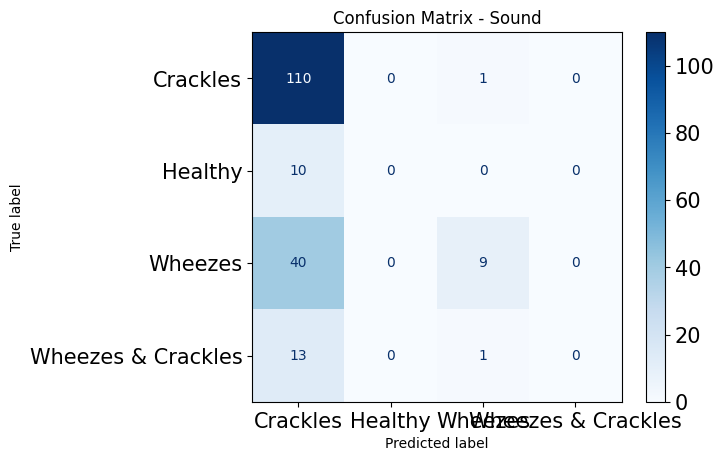

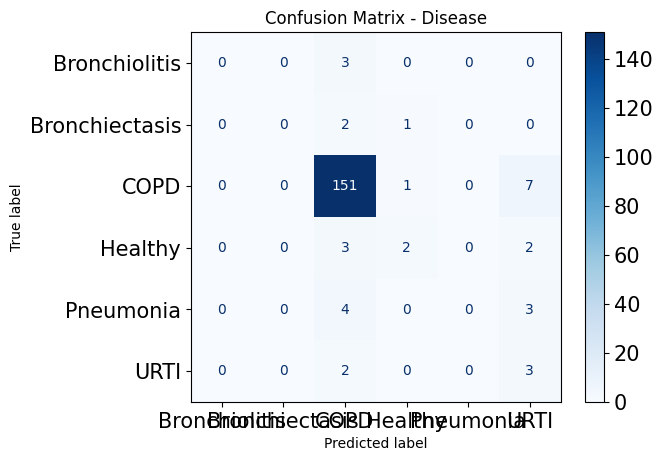

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming classpreds_sound and classpreds_disease are the predicted classes for sound and disease
cm_sound = confusion_matrix(y_testclass_sound, classpreds_sound)
disp_sound = ConfusionMatrixDisplay(confusion_matrix=cm_sound, display_labels=c_names_sound)

cm_disease = confusion_matrix(y_testclass_disease, classpreds_disease)
disp_disease = ConfusionMatrixDisplay(confusion_matrix=cm_disease, display_labels=c_names_disease)

# Plot confusion matrix for sound
disp_sound.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Sound')
plt.show()

# Plot confusion matrix for disease
disp_disease.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Disease')
plt.show()

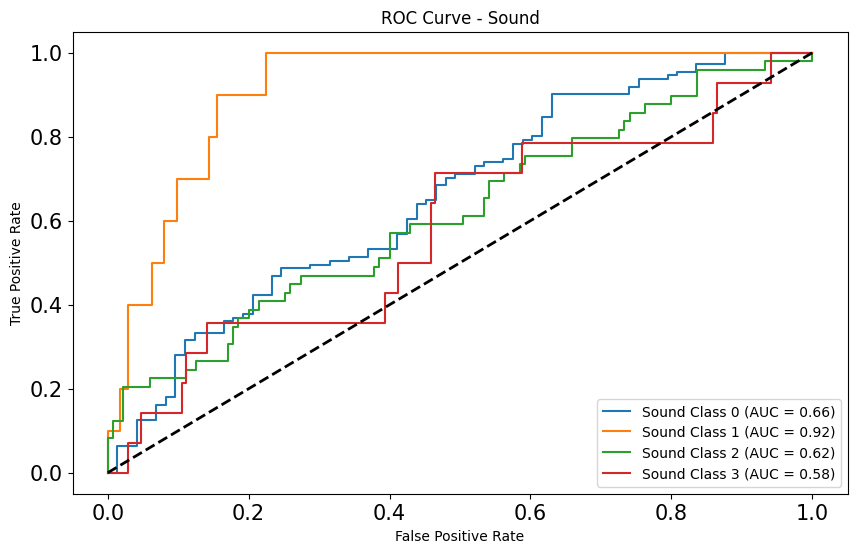

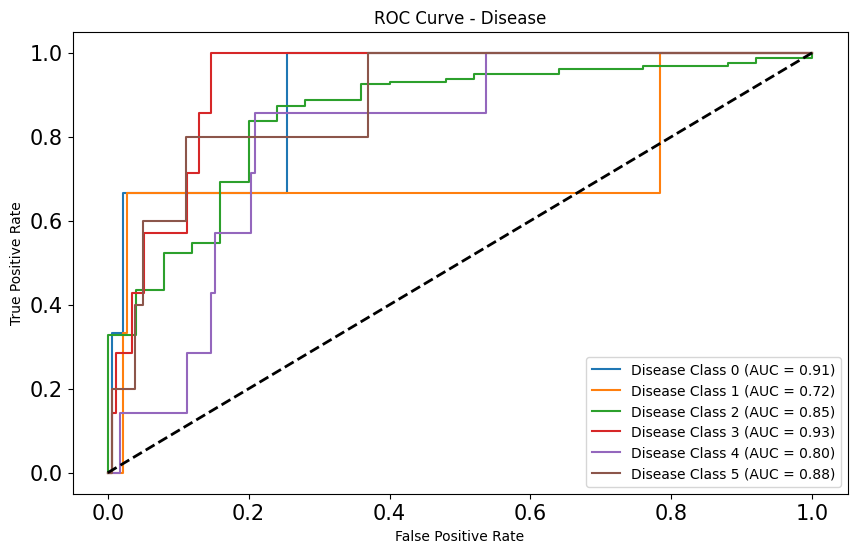

In [21]:
from sklearn.metrics import roc_curve, auc

# Assuming preds_sound and preds_disease are the predictions for sound and disease
fpr_sound = dict()
tpr_sound = dict()
roc_auc_sound = dict()

fpr_disease = dict()
tpr_disease = dict()
roc_auc_disease = dict()

# ROC curve and AUC for sound
for i in range(num_labels_sound):
    fpr_sound[i], tpr_sound[i], _ = roc_curve(y_test_sound[:, i], preds_sound[:, i])
    roc_auc_sound[i] = auc(fpr_sound[i], tpr_sound[i])

# ROC curve and AUC for disease
for i in range(num_labels_disease):
    fpr_disease[i], tpr_disease[i], _ = roc_curve(y_test_disease[:, i], preds_disease[:, i])
    roc_auc_disease[i] = auc(fpr_disease[i], tpr_disease[i])

# Plot ROC curves for sound
plt.figure(figsize=(10, 6))
for i in range(num_labels_sound):
    plt.plot(fpr_sound[i], tpr_sound[i], label=f'Sound Class {i} (AUC = {roc_auc_sound[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Sound')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for disease
plt.figure(figsize=(10, 6))
for i in range(num_labels_disease):
    plt.plot(fpr_disease[i], tpr_disease[i], label=f'Disease Class {i} (AUC = {roc_auc_disease[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Disease')
plt.legend(loc="lower right")
plt.show()


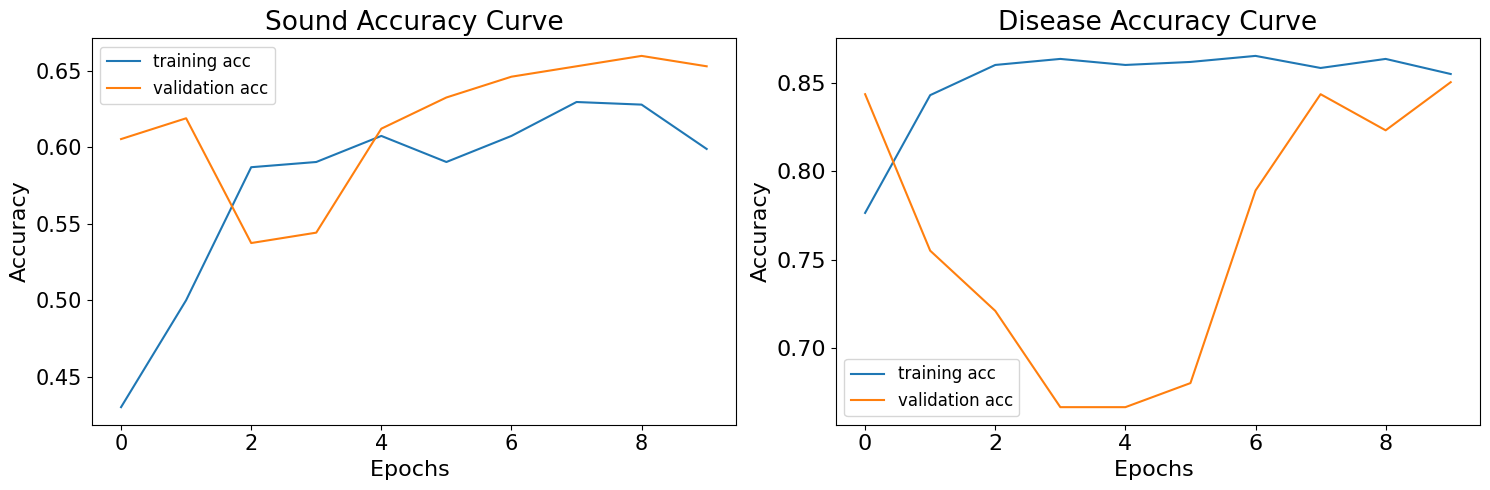

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Sound Accuracy Curve', fontsize=19)
plt.plot(history.history['sound_output_accuracy'], label='training acc')
plt.plot(history.history['val_sound_output_accuracy'], label='validation acc')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.title('Disease Accuracy Curve', fontsize=19)
plt.plot(history.history['disease_output_accuracy'], label='training acc')
plt.plot(history.history['val_disease_output_accuracy'], label='validation acc')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


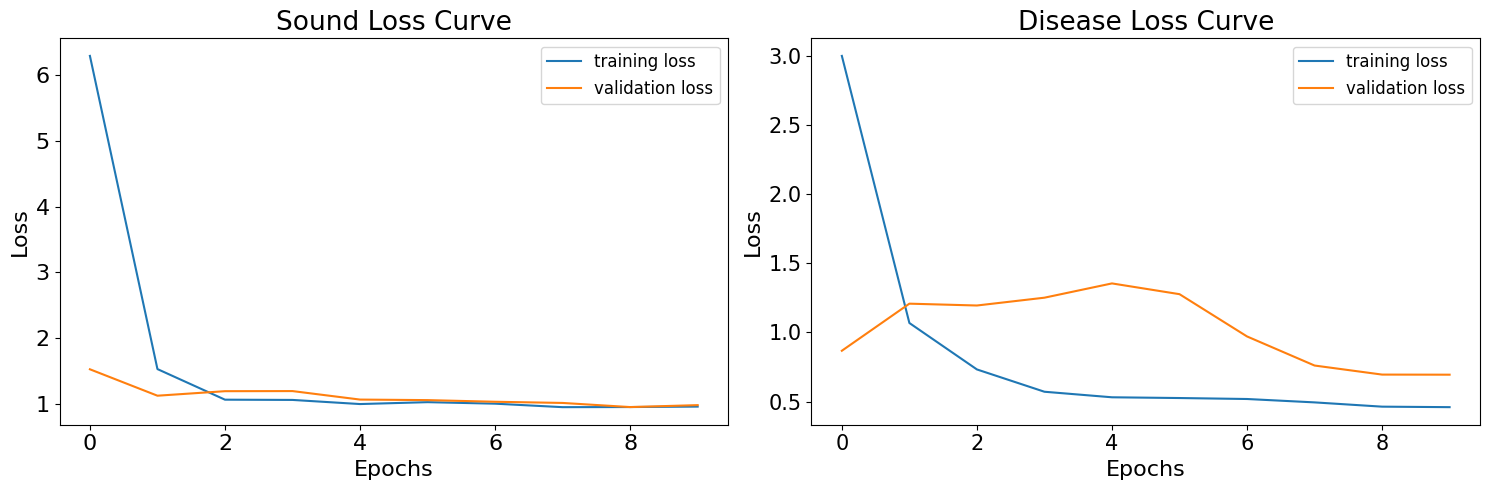

In [23]:
plt.figure(figsize=(15, 5))

# Sound model loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['sound_output_loss'], label='training loss')
plt.plot(history.history['val_sound_output_loss'], label='validation loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=12)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.title('Sound Loss Curve', fontsize=19)

# Disease model loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['disease_output_loss'], label='training loss')
plt.plot(history.history['val_disease_output_loss'], label='validation loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=12)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.title('Disease Loss Curve', fontsize=19)

plt.tight_layout()
plt.show()
